# Burgers Optimization with a Physics-Informed NN

Burgers example $u=...$
at $t=0$ , sine function (boundary_t0)
at sides $t \in [0,1], u=0$ (open_boundary)

Note that we're still sampling with 128 points ($n=128), but now we have a discretization via the NN, so we can 
also sample points inbetween; similar to linear interpolatoin or basis functions for FEM, just now the NN internally determines how to use its degrees of freedom to construct the basis functions. So we have no direct control over the reconstruction.

## Preliminaries

In [1]:
from phi.tf.flow import *

#rnd = TF_BACKEND  # sample different points in the domain each iteration
rnd = math.choose_backend(1)  # use same random points for all iterations

/home/thuerey/phiflow/phi/tf/__init__.py:7: UserWarning: TensorFlow 2 is not fully supported by PhiFlow.
  warnings.warn('TensorFlow 2 is not fully supported by PhiFlow.')


Could not load resample cuda libraries: CUDA binaries not found at /home/thuerey/phiflow/phi/tf/cuda/build/resample.so. Run "python setup.py cuda" to compile them


/home/thuerey/anaconda3/envs/tf/lib/python3.8/_collections_abc.py:743: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  for key in self._mapping:
/home/thuerey/anaconda3/envs/tf/lib/python3.8/_collections_abc.py:744: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  yield (key, self._mapping[key])
/home/thuerey/phiflow/phi/viz/display.py:80: UserWarning: GUI is disabled because of missing dependencies: No module named 'imageio'. To install all dependencies, run $ pip install phiflow[gui]
  warnings.warn('GUI is disabled because of missing dependencies: %s. To install all dependencies, run $ pip install phiflow[gui]' % import_error)
/home/thuerey/phiflow/phi/tf/flow.py:15: UserWarning: TensorFlow-CUDA solver is not available. To compile it, download phiflow sources and run
$ python setup.py tf_cuda
before reinstalling phiflow.
  warnings.warn("TensorFlow-CUDA solver is not available. To 

We're important phiflow here, but we won't use it to compute a solution to the PDE. Now we'll instead use the  derivatives of an NN (as explained in the previous section) to set up a loss formulation to train an NN.

In [2]:
def network(x, t):
    """ Dense neural network with 8 hidden layers and 3021 parameters in total.
        Parameters will only be allocated once (auto reuse).
    """
    y = math.stack([x, t], axis=-1)
    for i in range(8):
        y = tf.layers.dense(y, 20, activation=tf.math.tanh, name='layer%d' % i, reuse=tf.AUTO_REUSE)
    return tf.layers.dense(y, 1, activation=None, name='layer_out', reuse=tf.AUTO_REUSE)

def f(u, x, t):
    """ Physics-based loss function with Burgers equation """
    u_t = gradients(u, t)
    u_x = gradients(u, x)
    u_xx = gradients(u_x, x)
    return u_t + u*u_x - (0.01 / np.pi) * u_xx

def boundary_tx(N):
    x = np.linspace(-1,1,128)
    # precomputed solution from forward simulation:
    u = np.asarray( [0.008612174447657694, 0.02584669669548606, 0.043136357266407785, 0.060491074685516746, 0.07793926183951633, 0.0954779141740818, 0.11311894389663882, 0.1308497114054023, 0.14867023658641343, 0.1665634396808965, 0.18452263429574314, 0.20253084411376132, 0.22057828799835133, 0.23865132431365316, 0.25673879161339097, 0.27483167307082423, 0.2929182325574904, 0.3109944766354339, 0.3290477753208284, 0.34707880794585116, 0.36507311960102307, 0.38303584302507954, 0.40094962955534186, 0.4188235294008765, 0.4366357052408043, 0.45439856841363885, 0.4720845505219581, 0.4897081943759776, 0.5072391070000235, 0.5247011051514834, 0.542067187709797, 0.5593576751669057, 0.5765465453632126, 0.5936507311857876, 0.6106452944663003, 0.6275435911624945, 0.6443221318186165, 0.6609900633731869, 0.67752574922899, 0.6939334022562877, 0.7101938106059631, 0.7263049537163667, 0.7422506131457406, 0.7580207366534812, 0.7736033721649875, 0.7889776974379873, 0.8041371279965555, 0.8190465276590387, 0.8337064887158392, 0.8480617965162781, 0.8621229412131242, 0.8758057344502199, 0.8891341984763013, 0.9019806505391214, 0.9143881632159129, 0.9261597966464793, 0.9373647624856912, 0.9476871303793314, 0.9572273019669029, 0.9654367940878237, 0.9724097482283165, 0.9767381835635638, 0.9669484658390122, 0.659083299684951, -0.659083180712816, -0.9669485121167052, -0.9767382069792288, -0.9724097635533602, -0.9654367970450167, -0.9572273263645859, -0.9476871280825523, -0.9373647681120841, -0.9261598056102645, -0.9143881718456056, -0.9019807055316369, -0.8891341634240081, -0.8758057205293912, -0.8621229450911845, -0.8480618138204272, -0.833706571569058, -0.8190466131476127, -0.8041372124868691, -0.7889777195422356, -0.7736033858767385, -0.758020740007683, -0.7422507481169578, -0.7263049162371344, -0.7101938950789042, -0.6939334061553678, -0.677525822052029, -0.6609901538934517, -0.6443222327338847, -0.6275436932970322, -0.6106454472814152, -0.5936507836778451, -0.5765466491708988, -0.5593578078967361, -0.5420672759411125, -0.5247011730988912, -0.5072391580614087, -0.4897082914472909, -0.47208460952428394, -0.4543985995006753, -0.4366355580500639, -0.41882350871539187, -0.40094955631843376, -0.38303594105786365, -0.36507302109186685, -0.3470786936847069, -0.3290476440540586, -0.31099441589505206, -0.2929180880304103, -0.27483158663081614, -0.2567388003912687, -0.2386513127155433, -0.22057831776499126, -0.20253089403524566, -0.18452269630486776, -0.1665634500729787, -0.14867027528284874, -0.13084990929476334, -0.1131191325854089, -0.09547794429803691, -0.07793928430794522, -0.06049114408297565, -0.0431364527809777, -0.025846763281087953, -0.00861212501518312] );
    t = np.asarray(rnd.ones_like(x)) * 0.5
    perm = np.random.permutation(128) 
    return (x[perm])[0:N], (t[perm])[0:N], (u[perm])[0:N]

def _ALT_t0(N): # alternative, impose original initial state at t=0
    x = rnd.random_uniform([N], -1, 1)
    t = rnd.zeros_like(x)
    u = - math.sin(np.pi * x)
    return x, t, u

def open_boundary(N):
    t = rnd.random_uniform([N], 0, 1)
    x = math.concat([math.zeros([N//2]) + 1, math.zeros([N//2]) - 1], axis=0)
    u = math.zeros([N])
    return x, t, u

# out = boundary_tx(20)
# print(len(out[0]))
# print(out[0][0:10])
# print(out[2][0:10])
# a=np.asarray([1,2,3])
# perm=np.random.permutation(3)
# c=(a[b])[0:2]
# print(c)

Setup sampling points in inner domain

In [3]:
# generate array with positions: 
#   -1 to 1 spatial with 128 cells
#   0 to 1 in time with 1+32 timesteps
n=128
grids_xt = np.meshgrid(np.linspace(-1, 1, n), np.linspace(0, 1, 33), indexing='ij')
grid_x, grid_t = [tf.convert_to_tensor(t, tf.float32) for t in grids_xt]

# # gx ,gt = 
# #[tf.convert_to_tensor(t, tf.float32) 
# # for t in np.meshgrid( np.linspace(-1, 1, 128), np.linspace(0, 1, 33), indexing='ij')]

# for t in np.meshgrid( np.linspace(-1, 1, 128), np.linspace(0, 1, 33), indexing='ij'):
#     print(format(t.shape))
#     print(format(t))

# #tx = np.meshgrid( np.linspace(-1, 1, 128), indexing='ij')
# print(format(grid_x))
# print(format(grid_x.shape))

# create 4D tensor with batch and channel dimensions in addition to space and time
# in this case gives shape=(1, n, 33, 1)
grid_u = math.expand_dims(network(grid_x, grid_t))

/home/thuerey/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/thuerey/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Helper to show (see below)

Size of grid_u: (1, 128, 33, 1)
Randomly initialized network state:


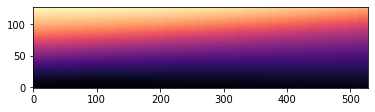

In [4]:
# test image output
import matplotlib.pyplot as plt
print("Size of grid_u: "+format(grid_u.shape))

session = Session(None)
session.initialize_variables()

def show_state(a, run_session=True):
    global session
    if run_session: a = session.run(a) # special for showing NN results, run through TF 

    # we only have 33 time steps, blow up by a factor of 2^4 to make it easier to see
    # (could also be done with more evaluations of network)
    for i in range(4):
        a = np.concatenate( [a,a] , axis=3)
    a = np.reshape( a, [a.shape[1],a.shape[2]*a.shape[3]] )
    #print(a.shape)
    plt.imshow(a, origin='upper', cmap='magma')
    
print("Randomly initialized network state:")
show_state(grid_u)

## The loss functions & training

set up losses...

Note: very slow, needs _lots_ of iterations, only 10k for testing by default (`iters`), increase to get better results.

In [5]:
# Boundary loss
num_sample_points_bnd = 100
x_bc, t_bc, u_bc = [math.concat([v_t0, v_x], axis=0) for v_t0, v_x in zip(boundary_tx(num_sample_points_bnd), open_boundary(num_sample_points_bnd))]
x_bc, t_bc, u_bc = np.asarray(x_bc,dtype=np.float32), np.asarray(t_bc,dtype=np.float32) ,np.asarray(u_bc,dtype=np.float32)
#with app.model_scope():
loss_u = math.l2_loss(network(x_bc, t_bc)[:, 0] - u_bc)  # normalizes by first dimension, N_bc

# Physics loss inside of domain
num_sample_points_inner = 1000
x_ph, t_ph = tf.convert_to_tensor(rnd.random_uniform([num_sample_points_inner], -1, 1)), tf.convert_to_tensor(rnd.random_uniform([num_sample_points_inner], 0, 1))
loss_ph = math.l2_loss(f(network(x_ph, t_ph)[:, 0], x_ph, t_ph))  # normalizes by first dimension, N_ph

# Combine
ph_factor = 1.
loss = loss_u + ph_factor * loss_ph # allows us to control the relative influence of loss_ph 

optim = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(loss)
#optim = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss) # not much benefit here


/home/thuerey/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/thuerey/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [6]:
session.initialize_variables()

import time
start = time.time()

iters = 10000
for optim_step in range(iters+1):
  _, loss_value = session.run([optim, loss])
  if optim_step%500==0: 
        print('Step %d, loss: %f' % (optim_step,loss_value))
        #show_state(grid_u)
        
end = time.time()
print("Runtime {:.2f}s".format(end-start))

Step 0, loss: 0.238804
Step 500, loss: 0.051395
Step 1000, loss: 0.045798
Step 1500, loss: 0.043285
Step 2000, loss: 0.041360
Step 2500, loss: 0.039480
Step 3000, loss: 0.037504
Step 3500, loss: 0.035440
Step 4000, loss: 0.033171
Step 4500, loss: 0.031074
Step 5000, loss: 0.029556
Step 5500, loss: 0.028347
Step 6000, loss: 0.026291
Step 6500, loss: 0.024694
Step 7000, loss: 0.022832
Step 7500, loss: 0.020840
Step 8000, loss: 0.035597
Step 8500, loss: 0.021575
Step 9000, loss: 0.080320
Step 9500, loss: 0.036767
Step 10000, loss: 0.034146
Runtime 77.39s


This training can take a significant amount of time, around 1 minute on a typical notebook, but at least the error goes down significantly, and the network seems to successfully converge to a solution.

Let's show the reconstruction of the network, by evaluating the network at the centers of a regular grid, so that we can show the solution as an image. Note that this is actually fairly expensive, we have to run through the whole network with a few thousand weights for all of the $128 \times 32$ points in the grid.

It looks pretty good on first sight, though:


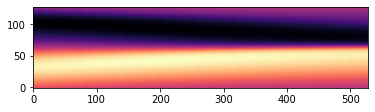

In [7]:
show_state(grid_u) # note, this helper internally does a `sess.run()`

---

## Evaluation

Let's compare solution in a bit more detail. Here are the actual sample points used for constraining the solution (at time step 16, $t=1/2$) shown in gray, versus the reconstructed solution in blue:


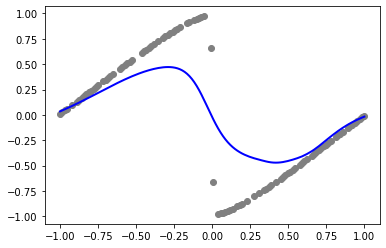

In [8]:
u = session.run(grid_u)
#[u,gx,gt] = session.run([grid_u,grid_x,grid_t]) # print(gt[0:5,17]) # check time...
# solution is imposed at t=1/2 , which is 16 in the array
bc_tx = 16 
uT = u[0,:,bc_tx,0]

fig = plt.figure().gca()
fig.plot(np.linspace(-1,1,len(uT)), uT, lw=2, color='blue')
fig.scatter(x_bc[0:100], u_bc[0:100], color='gray')


Not too bad at the sides of the domain (the Dirichlet boundary conditions $u=0$ are fulfilled), but the shock at $x=0$ is not well represented.

Let's check how well the initial state at $t=0$ was reconstructed. That's the most interesting, and toughest part of the problem (the rest basically follows from the model equation and boundary conditions, given the first state).

And turns out, it's actually not that great, blue curve from PINN quite far away from constraits (in gray)... Solution get's better with larger number of iterations, but requires a surprisingly large number of them for a fairly simple case. The shock in the middle is not well recovered (the maximum is still much too low).

... shown in blue, compared ot the (known) ground truth solution in gray ...

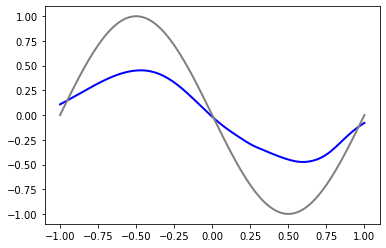

In [9]:
# ground truth solution at t0
t0gt = np.asarray( [ [-math.sin(np.pi * x) * 1.] for x in np.linspace(-1,1,n)] )

velP0 = u[0,:,0,0]

fig = plt.figure().gca()
fig.plot(np.linspace(-1,1,len(velP0)), velP0, lw=2, color='blue')
fig.plot(np.linspace(-1,1,len(t0gt)), t0gt, lw=2, color='gray') # optionally show GT, compare to blue


That's not very close...
especially the maximum / minimum at $x=\pm 1/2$ are far off, and the boudaries at $x=\pm 1$ are not fulfilled.

We have the forward simulator for this simulation, so we can use the $t=0$ solution of the network to 
evaluate how well the temporal evoluation was reconstructed by the PINN. This measures how well the temporal evolution of the model equation was captured via the soft constraints of the PINN loss.

(1, 128, 1)


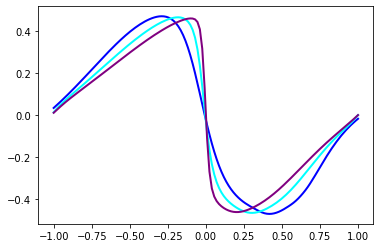

In [10]:
# re-run with phiflow from solution at t=0
dt = 1./32.
steps = 32-bc_tx # depends on where BCs were imposed
initial = u[...,bc_tx:(bc_tx+1),0] # np.reshape(u0, [1,len(u0),1]) 
print(initial.shape)

domain = Domain([n], boundaries=PERIODIC, box=box[-1:1])
state = [BurgersVelocity(domain, velocity=initial, viscosity=0.01/np.pi)]
physics = Burgers()

for i in range(steps):
    state.append( physics.step(state[-1],dt=dt) )

# we only need "velocity.data" from each phiflow state
vels = [x.velocity.data for x in state]

fig = plt.figure().gca()
pltx = np.linspace(-1,1,len(vels[0].flatten()))
fig.plot(pltx, vels[ 0].flatten(), lw=2, color='blue')
#fig.plot(pltx, vels[steps//4].flatten(), lw=2, color='green')
fig.plot(pltx, vels[steps//2].flatten(), lw=2, color='cyan')
fig.plot(pltx, vels[steps-1].flatten(), lw=2, color='purple')
#fig.plot(pltx, t0gt, lw=2, color='gray') # optionally show GT, compare to blue


Versus the PINN output:


(128,)


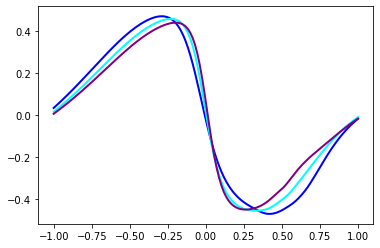

In [11]:
velP = [u[0,:,x,0] for x in range(33)]
print(velP[0].shape)

fig = plt.figure().gca()
fig.plot(pltx, velP[bc_tx+ 0].flatten(), lw=2, color='blue')
#fig.plot(pltx, velP[bc_tx+steps//4].flatten(), lw=2, color='green')
fig.plot(pltx, velP[bc_tx+steps//2].flatten(), lw=2, color='cyan')
fig.plot(pltx, velP[bc_tx+steps-1].flatten(), lw=2, color='purple')


Not surprisingly, the errors grow over time. Especially the steepening of the solution near the shock at $x=0$ is not "captured" well. It's a bit difficult to see in these two graphs, though, let's quantify the error and show the actual difference:

[(2048,), (2048,)]
Mean absolute error across 16 steps: 0.01397


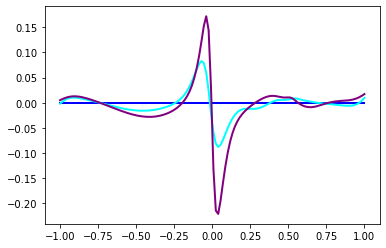

In [20]:
error = np.sum( np.abs( np.asarray(vels[0:16]).flatten() - np.asarray(velP[bc_tx:bc_tx+steps]).flatten() )) / (steps*n)
print("Mean absolute error for re-simulation across {} steps: {:7.5f}".format(steps,error))

fig = plt.figure().gca()
fig.plot(pltx, (vels[0       ].flatten()-velP[bc_tx         ].flatten()), lw=2, color='blue')
#fig.plot(pltx, (vels[steps//4].flatten()-velP[bc_tx+steps//4].flatten()), lw=2, color='green')
fig.plot(pltx, (vels[steps//2].flatten()-velP[bc_tx+steps//2].flatten()), lw=2, color='cyan')
fig.plot(pltx, (vels[steps-1 ].flatten()-velP[bc_tx+steps-1 ].flatten()), lw=2, color='purple')

This should show a mean absolute error of ca. $1.4 \cdot 10^{-2}$, which is significant for the value range of the simulation.

And for comparison with the forward simulation and following cases, here are also all steps over time with a color map... (note x axis does not show actual simulation time)

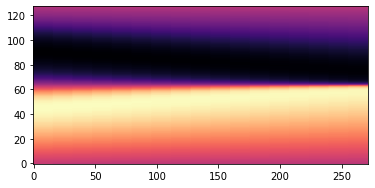

In [13]:
# show solution again as full image over time
sn = np.concatenate(vels, axis=-1)
sn = np.reshape(sn, list(sn.shape)+[1] ) # print(sn.shape)

show_state(sn, run_session=False)

More important, though, the mean absolute error (MAE) for the whole solution, i.e., from start to end:


In [ ]:
error_full = np.sum( np.abs( np.asarray(vels[0:16]).flatten() - np.asarray(velP[bc_tx:bc_tx+steps]).flatten() )) / (steps*n)
print("Overall MAE: {:7.5f}".format(error_full))

... store solution , just for comparison ...

In [29]:
vels = session.run(grid_u) # special for showing NN results, run through TF 
vels = np.reshape( vels, [vels.shape[1],vels.shape[2]] )

# save for comparison with other methods
np.savez_compressed("./temp/burgers-pinn-solution.npz",vels) ; print("Vels array shape: "+format(vels.shape))

Vels array shape: (128, 33)


---

## Next steps

This is just a starting point, the parameters were chosen to compare to run relatively quickly by default. The solution can be improved however. E.g., try to:

* Adjust parameters of the training to further decrease the error without making the solution diverge
* Adapt the NN architecture for further improvements (keep track of the weight count, though!)
* Activate a different optimizer, and observe the changing behavior (this typically requires adjusting the learning rate). Note that the more complex optimizers don't necessarily do better in this relatively simple example.
* Or modify the setup to make the test case more interesting: e.g., move the boundary conditions further back in time, to let the reconstruction go "further backward" in time.